In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "resnet18" #hybridqnn_shallow
# train args
batch_size = 2
epochs = 10
LR = 0.0001
n_samples_train = 128 #128
n_samples_test = 32 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "MNIST" # CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['0', '1']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

# Set preprocessing transforms
list_preprocessing = [
    transforms.Resize(input_resolution),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: -0.0013296129764057696 s


<Figure size 432x288 with 0 Axes>

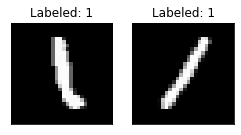

<Figure size 432x288 with 0 Axes>

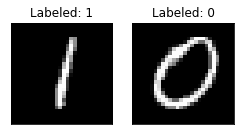

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        n_filts_fc1 = int(((((input_resolution[0]+7-4)/2)-4)/2)**2)*16
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

Batch 0, Loss: 0.6203333139419556
Batch 1, Loss: 0.5367475152015686
Batch 2, Loss: -0.4995359480381012
Batch 3, Loss: -0.5383416414260864
Batch 4, Loss: -1.4964802265167236
Batch 5, Loss: 0.4927327036857605
Batch 6, Loss: -1.4178295135498047
Batch 7, Loss: -0.5543209314346313
Batch 8, Loss: -0.5091373920440674
Batch 9, Loss: 0.599835991859436
Batch 10, Loss: -1.516977071762085
Batch 11, Loss: -1.50580894947052
Batch 12, Loss: -1.578896403312683
Batch 13, Loss: -0.43068280816078186
Batch 14, Loss: -0.4254828691482544
Batch 15, Loss: 0.42442411184310913
Batch 16, Loss: 0.2982161045074463
Batch 17, Loss: 0.5530551671981812
Batch 18, Loss: -1.3616595268249512
Batch 19, Loss: -0.6043495535850525
Batch 20, Loss: -0.5118367671966553
Batch 21, Loss: -0.5990685224533081
Batch 22, Loss: -0.4800107479095459
Batch 23, Loss: -0.6422582268714905
Batch 24, Loss: -0.4338560104370117
Batch 25, Loss: -0.5957666039466858
Batch 26, Loss: 0.4671710133552551
Batch 27, Loss: -1.6259174346923828
Batch 28, Los

Batch 100, Loss: -0.5584790706634521
Batch 101, Loss: 0.46992242336273193
Batch 102, Loss: -1.4356852769851685
Batch 103, Loss: 0.3962637484073639
Batch 104, Loss: -1.3976835012435913
Batch 105, Loss: -0.38895949721336365
Batch 106, Loss: -0.4863955080509186
Batch 107, Loss: -0.6445367932319641
Batch 108, Loss: 0.3204236328601837
Batch 109, Loss: -0.454794317483902
Batch 110, Loss: 0.31605201959609985
Batch 111, Loss: 0.6543455123901367
Batch 112, Loss: 0.4205969572067261
Batch 113, Loss: -1.6150810718536377
Batch 114, Loss: -0.5155202746391296
Batch 115, Loss: 0.45641928911209106
Batch 116, Loss: -0.3777918219566345
Batch 117, Loss: -1.3924193382263184
Batch 118, Loss: -0.5676878690719604
Batch 119, Loss: 0.5884114503860474
Batch 120, Loss: -1.4412611722946167
Batch 121, Loss: -0.43781977891921997
Batch 122, Loss: 0.4240599274635315
Batch 123, Loss: -1.433241367340088
Batch 124, Loss: -1.496884822845459
Batch 125, Loss: -0.555941104888916
Batch 126, Loss: -0.5404581427574158
Batch 127

Batch 71, Loss: -0.7221547961235046
Batch 72, Loss: -1.5041124820709229
Batch 73, Loss: -0.6067348718643188
Batch 74, Loss: -0.5789905786514282
Batch 75, Loss: -0.39492183923721313
Batch 76, Loss: -0.6204352974891663
Batch 77, Loss: -1.3759511709213257
Batch 78, Loss: -0.5021383762359619
Batch 79, Loss: 0.5612117648124695
Batch 80, Loss: -0.48125937581062317
Batch 81, Loss: -0.557915449142456
Batch 82, Loss: -1.4855897426605225
Batch 83, Loss: -0.5007556676864624
Batch 84, Loss: 0.544059157371521
Batch 85, Loss: -0.4449693560600281
Batch 86, Loss: -0.4766855835914612
Batch 87, Loss: -0.5777261853218079
Batch 88, Loss: -0.35272127389907837
Batch 89, Loss: -1.4747995138168335
Batch 90, Loss: -1.46510910987854
Batch 91, Loss: -0.36073386669158936
Batch 92, Loss: -0.4873790740966797
Batch 93, Loss: -0.35244959592819214
Batch 94, Loss: -0.44249987602233887
Batch 95, Loss: 0.5696088075637817
Batch 96, Loss: -1.578809142112732
Batch 97, Loss: 0.5495387315750122
Batch 98, Loss: 0.4261688590049

Batch 41, Loss: 0.4071049392223358
Batch 42, Loss: -0.4586257338523865
Batch 43, Loss: -1.4498238563537598
Batch 44, Loss: -0.6355332136154175
Batch 45, Loss: -0.633643627166748
Batch 46, Loss: -0.41044673323631287
Batch 47, Loss: -0.4991663694381714
Batch 48, Loss: -1.5511870384216309
Batch 49, Loss: -0.5891933441162109
Batch 50, Loss: -0.5486889481544495
Batch 51, Loss: -1.492058277130127
Batch 52, Loss: -0.5785899758338928
Batch 53, Loss: 0.45945680141448975
Batch 54, Loss: 0.4498296082019806
Batch 55, Loss: -1.3742351531982422
Batch 56, Loss: -0.5976629853248596
Batch 57, Loss: -1.3743149042129517
Batch 58, Loss: 0.4905184209346771
Batch 59, Loss: -0.43953320384025574
Batch 60, Loss: -1.5528979301452637
Batch 61, Loss: -1.5596961975097656
Batch 62, Loss: -0.539635419845581
Batch 63, Loss: -0.4741567075252533
Batch 64, Loss: -0.35231295228004456
Batch 65, Loss: -1.5737426280975342
Batch 66, Loss: -0.5571724772453308
Batch 67, Loss: 0.49781155586242676
Batch 68, Loss: -1.490153551101

Batch 12, Loss: -1.409783124923706
Batch 13, Loss: -0.6208609938621521
Batch 14, Loss: -0.49421295523643494
Batch 15, Loss: -1.582824468612671
Batch 16, Loss: 0.4877547323703766
Batch 17, Loss: -0.4229162633419037
Batch 18, Loss: 0.3396177589893341
Batch 19, Loss: -0.544754147529602
Batch 20, Loss: 0.3910951614379883
Batch 21, Loss: 0.5048235654830933
Batch 22, Loss: -0.6488536596298218
Batch 23, Loss: 0.5495760440826416
Batch 24, Loss: -0.651607871055603
Batch 25, Loss: -1.3688734769821167
Batch 26, Loss: -0.6020755767822266
Batch 27, Loss: -0.5576571226119995
Batch 28, Loss: -0.5516939163208008
Batch 29, Loss: -1.421389102935791
Batch 30, Loss: 0.5235464572906494
Batch 31, Loss: -0.6896528601646423
Batch 32, Loss: -0.6238536834716797
Batch 33, Loss: -0.6015360355377197
Batch 34, Loss: 0.4941079020500183
Batch 35, Loss: 0.43376457691192627
Batch 36, Loss: -1.476656436920166
Batch 37, Loss: -1.413181185722351
Batch 38, Loss: -0.5650221705436707
Batch 39, Loss: 0.49339863657951355
Batch

Batch 112, Loss: 0.593044638633728
Batch 113, Loss: 0.4849753975868225
Batch 114, Loss: 0.4010970890522003
Batch 115, Loss: 0.5460138320922852
Batch 116, Loss: -0.4625868499279022
Batch 117, Loss: -0.6189586520195007
Batch 118, Loss: 0.5407217741012573
Batch 119, Loss: -0.5192348957061768
Batch 120, Loss: -0.598384439945221
Batch 121, Loss: -1.3499689102172852
Batch 122, Loss: -1.3898823261260986
Batch 123, Loss: -0.6741741895675659
Batch 124, Loss: -0.5783237218856812
Batch 125, Loss: 0.5680116415023804
Batch 126, Loss: -1.4137134552001953
Batch 127, Loss: 0.5070372819900513
Training [90%]	Loss: -0.5492
Batch 0, Loss: 0.3806006610393524
Batch 1, Loss: -1.4078508615493774
Batch 2, Loss: -1.5894758701324463
Batch 3, Loss: -0.41959381103515625
Batch 4, Loss: -1.4489407539367676
Batch 5, Loss: -0.5416423678398132
Batch 6, Loss: -0.5054429173469543
Batch 7, Loss: -0.5180999636650085
Batch 8, Loss: 0.48552507162094116
Batch 9, Loss: 0.436032772064209
Batch 10, Loss: -0.4148343801498413
Batc

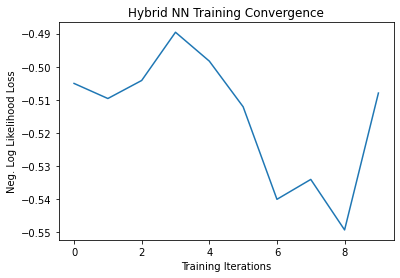

Training time: 0.0008359469939023256 s


In [7]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

In [8]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


Performance on test data:
	Loss: -0.5093
	Accuracy: 50.0%
Test time: -0.00015425699530169368 s


<Figure size 432x288 with 0 Axes>

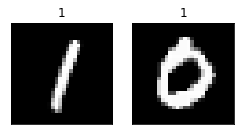

<Figure size 432x288 with 0 Axes>

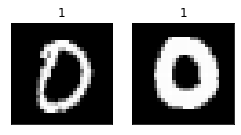

In [9]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 